# beams tutorial

## Setup

Clone the repository to your desired location using `git clone https://github.com/rushinc/beams`.
Append the `beams` parent directory to your `PYTHONPATH`. Easiest is to use the `os` module.
Update the path in the cell below and that's it!

In [1]:
import os
os.sys.path.append('/home/rushin/Documents/Python/') # Modify this line

import beams as bm
import numpy as np
import matplotlib.pyplot as plt

## Inputs

First, we define all the input parameters which define the geometry of our structure as well as the frequency and momentum to solve at.

We begin with the wavelength or frequency. In units where the speed of light $c=1$ the frequency and wavelength are simply the inverse of each other.

The unit for wavelength is chosen to be μm but is not important as long as all other geometric parameters are defined in the same units.

In [2]:
y = 1.55
freq = 1 / y

The angle of incident light is determined by the momentum along the $x$- and $y$-directions. For normal incidence $k_x = k_y = 0$.

In [3]:
kx = 0
ky = 0
k = bm.Vector2d(kx, ky)

The accuracy and the computational size of the problem is determined by the number of modes solved for. The size of matrices will be proportional to $N = N_x N_y$.

The time complexity of the linear algebra routines is $\mathcal{O}(N^3)$. So the serial version should scale accordingly.

In [4]:
N_x = 9
N_y = 9
N_modes = bm.Vector2d(N_x, N_y)

## Materials

The physical response of the materials can be defined and accessed using `beams.materials.Material`. For now, we will only use this interface to assign a frequency-independent complex permittivity or refractive index. Later, this functionality will be extended to magnetic permeability as well as frequency-dependent dispersion.

The materials we use for this example are air, silicon and glass.

In [5]:
air = bm.Material()
SiO2 = bm.Material(index=1.5)
Si = bm.Material(index=3.4)

## Geometry

The sensor we will analyze here is from [this paper](https://www.degruyter.com/view/journals/nanoph/ahead-of-print/article-10.1515-nanoph-2020-0008/article-10.1515-nanoph-2020-0008.xml). The unit cell (from Fig. 2) is reproduced below.

![Unit cell](unitcell.png)

The values of the parameters shown above are defined as follows:

In [6]:
px = .810
py = px
p = bm.Vector2d(px, py)
h = .320 # = h_c
L = .600 
w_1 = .230
w_2 = .190
g = .125
C_1 = bm.Vector2d(y=-(w_1 + g)/2)       # Center of Si bar 1
C_2 = bm.Vector2d(y=(w_2 + g)/2)        # Center of Si bar 1

Now we can construct the rectangles using the `beams.shapes` module. The `Shape` class takes three arguments to construct; these determine the material of the shape, the center, and a function which returns a `boolean` for every `Vector2d` input indicating whether the point lies inside or outside the shape.

Currently, this module only defines a rectangle but adding more shapes is pretty trivial.

In [7]:
bar1 = bm.Rectangle(size=bm.Vector2d(L, w_1), center=C_1, material=Si)
bar2 = bm.Rectangle(size=bm.Vector2d(L, w_2), center=C_2, material=Si)

The most important class in `beams` is the `Layer` class. `Layer` objects solve the eigenvalue problem of Maxwell's equations in 2D.

To define a layer we pass in a list of shapes that belong to the layer, a default material which is present at all points which do not lie in the interior of the passed shapes, and an integer resolution. 

The resolution is number of pixels our length scale is divided in. So a resolution of $4000$ as passed below means that one pixel on our grid is equal to $1/4000$ μm. This resolution is what determines the size of the FFT problem which should scale as $\mathcal{O}(r \log r)$.

In [8]:
res = 4000
shapes = [bar1, bar2]
bars = bm.Layer(0, res, shapes, air)

Now that a layer has been initialized we can run some preliminary tests on how the layer looks like. First, let us see if the shapes have been correctly defined. The `Layer.grid(period, value='id')` method will return of grid of the specified value which we can quickly plot using `matplotlib`.

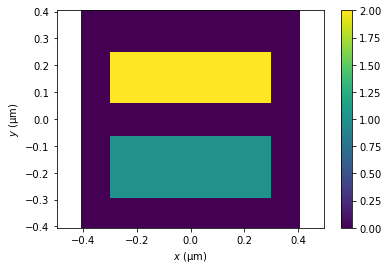

In [9]:
xarr = np.arange(-px / 2, px / 2, 1 / res)
yarr = np.arange(-py / 2, py / 2, 1 / res)
sgrid = bars.grid(period=p)
plt.pcolormesh(xarr, yarr, sgrid.T)
plt.xlim([-px / 2, px / 2])
plt.xlabel('$x$ (μm)')
plt.ylim([-py / 2, py / 2])
plt.ylabel('$y$ (μm)')
plt.axis('equal')
plt.colorbar()
plt.show()

This does look like a 2D projection of the two silicon bars from the unit cell. The different colors of the two rectangles indicate that these are distinct shapes having a unique id. Mostly though, we just want see the permittivity distribution. To do that we can pass `value='eps'` to `Layer.grid`.

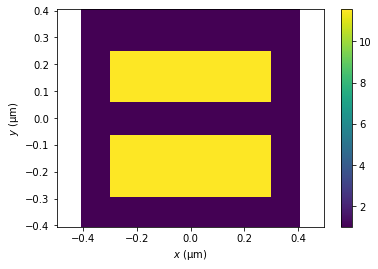

In [10]:
epsgrid = bars.grid(period=p, value='eps')
plt.pcolormesh(xarr, yarr, epsgrid.T)
plt.xlim([-px / 2, px / 2])
plt.xlabel('$x$ (μm)')
plt.ylim([-py / 2, py / 2])
plt.ylabel('$y$ (μm)')
plt.axis('equal')
plt.colorbar()
plt.show()

This shows that the two bars have the same permittivty $\epsilon \approx 12$.



Now that everything looks good we can run the most intensive computation on this layer. Everything needed to solve a layer is contained in the `Layer.eigs` method. This method internally calls `Layer.fft` and `Layer.mode_solve` methods. Both these methods are defined in `layer.py` and should be timed separately. They compute the FFT and the eigendecomposition respectively.

As things stand, this method will spit out a bunch of matrices. Later, these matrices will be used to solve the large linear system.

In [11]:
bars.eigs(freq, k, p, N_modes)

(array([1.06923750e+01+1.92277217e-16j, 1.06664516e+01+3.96246978e-16j,
        1.06764557e+01+4.75840142e-16j, 1.06828928e+01-4.96335204e-17j,
        9.42231592e+00+1.16143158e-15j, 9.41317788e+00+8.82432767e-16j,
        9.38719913e+00+4.32171795e-16j, 9.38036606e+00-7.87941777e-16j,
        9.31639237e+00+2.17115815e-15j, 9.28081399e+00-9.59596675e-16j,
        9.29109073e+00-2.69552867e-15j, 9.25127477e+00-1.04161922e-15j,
        9.16894160e+00+5.70318738e-16j, 9.16227904e+00+2.59086825e-15j,
        9.00531362e+00+4.96435680e-15j, 9.01340701e+00+4.44658748e-15j,
        2.72665311e-16+2.55536517e+00j, 4.60224127e-16-2.07691434e+00j,
        7.42892087e-16-1.67988390e+00j, 2.66225285e-15+1.31557865e+00j,
        5.19069322e-16-9.83871615e-01j, 2.86881697e-15-9.40824334e-01j,
        4.26399089e-15-3.74575642e-01j, 8.39786344e+00-9.47483204e-02j,
        8.34472821e+00-1.30963375e-01j, 8.39786344e+00+9.47483204e-02j,
        8.34472821e+00+1.30963375e-01j, 8.38928165e+00-1.2284492